In [1]:
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q http://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
# !tar -xvf spark-2.4.0-bin-hadoop2.7.tgz
# !pip install -q findspark
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"
import findspark
findspark.init()

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

In [3]:
# %cd '/content/gdrive/My Drive/LDS9/Practice/Chapter6/'

In [4]:
# import libraries
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from datetime import datetime
from pyspark.sql import types 
from pyspark.sql.functions import regexp_extract, col
from pyspark.sql.functions import datediff
from pyspark.sql.functions import *

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import LinearRegressionModel
from pyspark.ml.linalg import Vector
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.classification import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import *
from pyspark.ml.feature import *
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [5]:
sc = SparkContext(master='local',appName='Cau1')

In [6]:
sc

<SparkContext master=local appName=Cau1>

In [7]:
spark = SparkSession(sc)

# Đọc dữ liệu

In [8]:
df = pd.read_excel('Data/womens-ecommerce-clothing-reviews/Womens_Clothing_E_Commerce_Reviews.xlsx', sheet_name='Reviews',engine='openpyxl')

In [9]:
df.head(3)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses


In [10]:
df.columns

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23481 non-null  int64 
 1   Clothing ID              23481 non-null  int64 
 2   Age                      23481 non-null  int64 
 3   Title                    19671 non-null  object
 4   Review Text              22636 non-null  object
 5   Rating                   23481 non-null  int64 
 6   Recommended IND          23481 non-null  int64 
 7   Positive Feedback Count  23481 non-null  int64 
 8   Division Name            23467 non-null  object
 9   Department Name          23467 non-null  object
 10  Class Name               23467 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [12]:
schema = StructType([StructField( 'Unnamed: 0', IntegerType(), True),StructField( 'Clothing ID', IntegerType(), True),StructField( 'Age', IntegerType(), True),StructField( 'Title', StringType(), True),StructField( 'Review Text', StringType(), True),StructField( 'Rating', IntegerType(), True), StructField('Recommended IND', IntegerType(),True),StructField('Positive Feedback Count', IntegerType(),True),StructField('Division Name', StringType(),True),StructField('Department Name', StringType(),True),StructField('Class Name', StringType(),True)])

In [13]:
data = spark.createDataFrame(data=df, schema= schema)                           

In [14]:
# Print the Schema of the DataFrame
data.printSchema()

root
 |-- Unnamed: 0: integer (nullable = true)
 |-- Clothing ID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Review Text: string (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Recommended IND: integer (nullable = true)
 |-- Positive Feedback Count: integer (nullable = true)
 |-- Division Name: string (nullable = true)
 |-- Department Name: string (nullable = true)
 |-- Class Name: string (nullable = true)



In [15]:
print((data.count(), len(data.columns)))

(23481, 11)


In [16]:
data.head(1)

[Row(Unnamed: 0=0, Clothing ID=767, Age=33, Title='NaN', Review Text='Absolutely wonderful - silky and sexy and comfortable', Rating=4, Recommended IND=1, Positive Feedback Count=0, Division Name='Initmates', Department Name='Intimate', Class Name='Intimates')]

In [17]:
data.show(3)

+----------+-----------+---+--------------------+--------------------+------+---------------+-----------------------+-------------+---------------+----------+
|Unnamed: 0|Clothing ID|Age|               Title|         Review Text|Rating|Recommended IND|Positive Feedback Count|Division Name|Department Name|Class Name|
+----------+-----------+---+--------------------+--------------------+------+---------------+-----------------------+-------------+---------------+----------+
|         0|        767| 33|                 NaN|Absolutely wonder...|     4|              1|                      0|    Initmates|       Intimate| Intimates|
|         1|       1080| 34|                 NaN|Love this dress! ...|     5|              1|                      4|      General|        Dresses|   Dresses|
|         2|       1077| 60|Some major design...|I had such high h...|     3|              0|                      0|      General|        Dresses|   Dresses|
+----------+-----------+---+------------------

In [18]:
data.columns

['Unnamed: 0',
 'Clothing ID',
 'Age',
 'Title',
 'Review Text',
 'Rating',
 'Recommended IND',
 'Positive Feedback Count',
 'Division Name',
 'Department Name',
 'Class Name']

In [19]:
# Chỉ lựa chọn một số thuộc tính để xây dựng model: ['Age', 'Title', 'Review Text', 'Rating','Positive Feedback Count','Recommended IND']
data_sub = data.select(['Age', 'Title', 'Review Text', 'Rating','Positive Feedback Count','Recommended IND'])

In [20]:
data_sub.show(3)

+---+--------------------+--------------------+------+-----------------------+---------------+
|Age|               Title|         Review Text|Rating|Positive Feedback Count|Recommended IND|
+---+--------------------+--------------------+------+-----------------------+---------------+
| 33|                 NaN|Absolutely wonder...|     4|                      0|              1|
| 34|                 NaN|Love this dress! ...|     5|                      4|              1|
| 60|Some major design...|I had such high h...|     3|                      0|              0|
+---+--------------------+--------------------+------+-----------------------+---------------+
only showing top 3 rows



In [21]:
# Kiểm tra dữ liệu trùng
data_sub.count() - data_sub.distinct().count()

677

In [22]:
data_sub  = data_sub.drop_duplicates()

In [23]:
# Kiểm tra lại
data_sub.count() - data_sub.distinct().count()

0

In [24]:
# Không còn dữ liệu trùng

In [25]:
# Kiểm tra dữ liệu Nan - Null

In [26]:
data_sub.select([count(when(isnan(c),c)).alias (c) for c in data_sub.columns]).show()

+---+-----+-----------+------+-----------------------+---------------+
|Age|Title|Review Text|Rating|Positive Feedback Count|Recommended IND|
+---+-----+-----------+------+-----------------------+---------------+
|  0| 3134|        170|     0|                      0|              0|
+---+-----+-----------+------+-----------------------+---------------+



In [27]:
# Chỉ có dữ liệu String có Nan, dữ liệu số không bị Nan

In [28]:
data_sub.select([count(when(isnull(c),c)).alias (c) for c in data_sub.columns]).show()

+---+-----+-----------+------+-----------------------+---------------+
|Age|Title|Review Text|Rating|Positive Feedback Count|Recommended IND|
+---+-----+-----------+------+-----------------------+---------------+
|  0|    0|          0|     0|                      0|              0|
+---+-----+-----------+------+-----------------------+---------------+



In [29]:
# Không có dữ liệu Null

In [30]:
data_sub.columns

['Age',
 'Title',
 'Review Text',
 'Rating',
 'Positive Feedback Count',
 'Recommended IND']

In [31]:
data_sub.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Review Text: string (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Positive Feedback Count: integer (nullable = true)
 |-- Recommended IND: integer (nullable = true)



In [32]:
df_pandas = data_sub.select(['Age',
 'Rating',
 'Positive Feedback Count',
 'Recommended IND']).toPandas()

In [33]:
for i in df_pandas.columns:
    a = data_sub.select(i).distinct()
    print(f'{i}: {a.count()}')

Age: 77
Rating: 5
Positive Feedback Count: 82
Recommended IND: 2


# Phân tích đơn biến

In [34]:
# Xem những thông tin thống kê chung của dữ liệu
data_sub.select(['Age', 'Rating', 'Positive Feedback Count', 'Recommended IND']).describe().show()

+-------+-----------------+------------------+-----------------------+------------------+
|summary|              Age|            Rating|Positive Feedback Count|   Recommended IND|
+-------+-----------------+------------------+-----------------------+------------------+
|  count|            22804|             22804|                  22804|             22804|
|   mean|43.29012453955446| 4.179793018768637|     2.6106384844764077|0.8178828275741098|
| stddev|12.34046914450934|1.1179378585631887|      5.769148170162659|0.3859495303676664|
|    min|               18|                 1|                      0|                 0|
|    max|               99|                 5|                    122|                 1|
+-------+-----------------+------------------+-----------------------+------------------+



## Biến liên tục

0. Age/


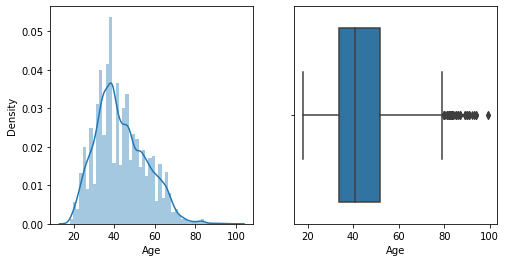

--------------------
1. Positive Feedback Count/


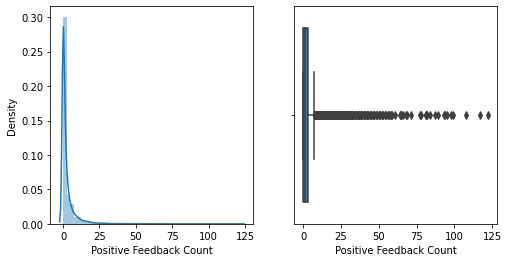

--------------------


In [35]:
# Biến liên tục:
stt = 0
lst_ltuc = ['Age','Positive Feedback Count']
for i in lst_ltuc:
    print(f'{stt}. {i}/')
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    sns.distplot(df_pandas[i])
    plt.subplot(1,2,2)
    sns.boxplot(df_pandas[i])
    plt.show()
    print('-'*20)
    stt+=1

## Biến phân loại:

In [36]:
df_Rating = data.groupBy('Rating').count().orderBy('count').toPandas()
df_Rating

,Rating,count
0,1,841
1,2,1564
2,3,2870
3,4,5076
4,5,13130


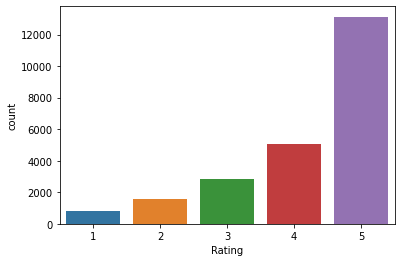

In [37]:
plt.figure(figsize=(6,4))
sns.barplot(data=df_Rating, x = df_Rating['Rating'], y = df_Rating['count'])
plt.show()

In [38]:
# Rating bằng 5 có số lượng cao nhất, và thấp dần về Rating bằng 1

In [39]:
df_Recommended = data.groupBy('Recommended IND').count().orderBy('count').toPandas()
df_Recommended

,Recommended IND,count
0,0,4169
1,1,19312


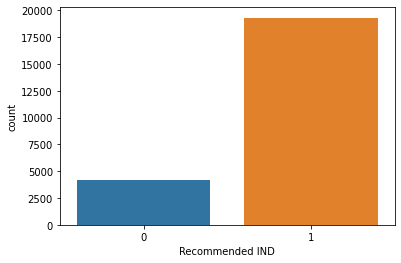

In [40]:
plt.figure(figsize=(6,4))
sns.barplot(data=df_Recommended, x = df_Recommended['Recommended IND'], y = df_Recommended['count'])
plt.show()

# Phân tích hai biến

## Phân tích hai biến Phân loại - Liên tục

In [41]:
lst_ploai = ['Rating','Recommended IND']

1/ Rating - Age:


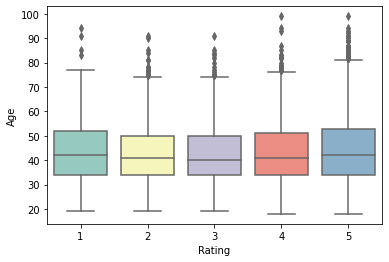

2/ Rating - Positive Feedback Count:


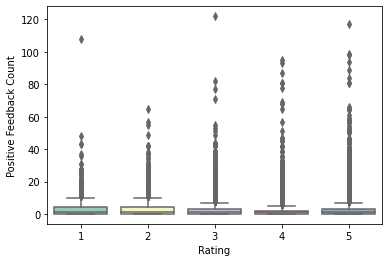

In [42]:
a = 1
for i in ['Rating']:
    for n in lst_ltuc:
        print(f'{a}/ {i} - {n}:')
        df_con = df_pandas[[i,n]]
#         print(df_sub.head())
        plt.figure(figsize=(6,4))
        sns.boxplot(x = i, y = n, data= df_con, palette='Set3')
        plt.show()
        a+=1

In [43]:
data_sub.show(3)

+---+----------------+--------------------+------+-----------------------+---------------+
|Age|           Title|         Review Text|Rating|Positive Feedback Count|Recommended IND|
+---+----------------+--------------------+------+-----------------------+---------------+
| 47|Flattering shirt|This shirt is ver...|     5|                      6|              1|
| 41|            Love|I absolutely love...|     5|                      2|              1|
| 37|       Just okay|I was looking for...|     3|                      0|              0|
+---+----------------+--------------------+------+-----------------------+---------------+
only showing top 3 rows



In [44]:
data_sub.groupBy('Rating').count().sort('count',ascending = False).show()

+------+-----+
|Rating|count|
+------+-----+
|     5|12594|
|     4| 4952|
|     3| 2860|
|     2| 1560|
|     1|  838|
+------+-----+



In [62]:
regex1 = RegexTokenizer(inputCol= 'Title', outputCol='regex_Title', pattern='\\W')
regex2 = RegexTokenizer(inputCol= 'Review Text', outputCol='regex_Text', pattern = '\\W')
remover1 = StopWordsRemover(inputCol='regex_Title', outputCol='stop_Title')
remover2= StopWordsRemover(inputCol='regex_Text', outputCol='stop_Text')
count_vec1 = CountVectorizer(inputCol='stop_Title', outputCol= 'c_vec_Title')
count_vec2 = CountVectorizer(inputCol='stop_Text', outputCol= 'c_vec_Text')
idf1 = IDF(inputCol='c_vec_Title', outputCol='tf_idf_Title')
idf2 = IDF(inputCol='c_vec_Text', outputCol='tf_idf_Text')
vectoass = VectorAssembler(inputCols= ['tf_idf_Text','tf_idf_Title','Age','Recommended IND','Positive Feedback Count',], outputCol= 'features')

In [63]:
pipe = Pipeline(stages=[regex1,regex2, remover1,remover2, count_vec1,count_vec2, idf1,idf2, vectoass])

In [64]:
pipe = pipe.fit(data_sub)

In [65]:
pipe_data = pipe.transform(data_sub)

In [66]:
pipe_data.show(2)

+---+----------------+--------------------+------+-----------------------+---------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Age|           Title|         Review Text|Rating|Positive Feedback Count|Recommended IND|        regex_Title|          regex_Text|         stop_Title|           stop_Text|         c_vec_Title|          c_vec_Text|        tf_idf_Title|         tf_idf_Text|            features|
+---+----------------+--------------------+------+-----------------------+---------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 47|Flattering shirt|This shirt is ver...|     5|                      6|              1|[flattering, shirt]|[this, shirt, is,...|[flattering, shirt]|[shirt, flatter

In [67]:
pipe_data.select('stop_Text','stop_Title').show(3, False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|stop_Text                                                                                                                                              |stop_Title         |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|[shirt, flattering, due, adjustable, front, tie, perfect, length, wear, leggings, sleeveless, pairs, well, cardigan, love, shirt]                      |[flattering, shirt]|
|[absolutely, love, bib, tee, probably, favorite, retailer, purchase, time, m, 5, 7, 140, pounds, small, perfect, fit, typically, wear, either, m, tops]|[love]             |
|[looking, basic, tee, one, ok, quality, okay, us, soft, liked, unfortunately, returning, item]                                   

In [68]:
data_final = pipe_data.select(['features','Rating'])

In [69]:
data_final = data_final.withColumnRenamed('Rating','label')

In [70]:
data_final.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(17829,[1,7,16,19...|    5|
|(17829,[1,4,6,7,9...|    5|
|(17829,[18,21,45,...|    3|
|(17829,[0,20,34,4...|    1|
|(17829,[3,12,21,2...|    5|
+--------------------+-----+
only showing top 5 rows



In [71]:
(train, test) = data_final.randomSplit([0.8,0.2])

# Áp dụng Model

In [81]:
model_nvb = NaiveBayes().fit(train)
model_dtree = DecisionTreeClassifier().fit(train)
model_rdf = RandomForestClassifier().fit(train)
model_lgt = LogisticRegression().fit(train)

In [82]:
preditions_nvb = model_nvb.transform(test)
preditions_dtree = model_dtree.transform(test)
preditions_rdf = model_rdf.transform(test)
preditions_lgt = model_lgt.transform(test)

In [84]:
table_nvb = preditions_nvb.groupBy('label','prediction').count()
table_dtree = preditions_dtree.groupBy('label','prediction').count()
table_rdf = preditions_rdf.groupBy('label','prediction').count()
table_lgt = preditions_lgt.groupBy('label','prediction').count()

In [85]:
table_nvb.show()
table_dtree.show()
table_rdf.show(), table_lgt.show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    2|       1.0|  103|
|    4|       3.0|  390|
|    4|       1.0|   42|
|    2|       4.0|   11|
|    1|       0.0|   61|
|    3|       4.0|   46|
|    5|       4.0| 1848|
|    1|       3.0|    9|
|    3|       1.0|  116|
|    4|       4.0|  362|
|    5|       2.0|   79|
|    5|       1.0|   39|
|    1|       2.0|   45|
|    4|       0.0|   10|
|    2|       3.0|   29|
|    3|       2.0|  262|
|    3|       3.0|  122|
|    2|       2.0|  131|
|    1|       1.0|   51|
|    3|       0.0|   46|
+-----+----------+-----+
only showing top 20 rows

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    2|       1.0|    3|
|    4|       3.0|   30|
|    2|       4.0|    3|
|    3|       4.0|   53|
|    1|       3.0|  149|
|    5|       4.0|   74|
|    3|       1.0|    2|
|    4|       4.0|  121|
|    5|       5.0| 2343|
|    1|       5.0|    4|
|    1|       2.0|   12|
|    2|       3.0|  295|

(None, None)

In [86]:
acc_ecaluator = MulticlassClassificationEvaluator(metricName='accuracy')

In [87]:
nvb_acc = acc_ecaluator.evaluate(preditions_nvb)
dtree_acc = acc_ecaluator.evaluate(preditions_dtree)
rdf_acc = acc_ecaluator.evaluate(preditions_rdf)
lgt_acc = acc_ecaluator.evaluate(preditions_lgt)

In [88]:
print('Results')
print('-'*60)
print(f'A single Navibayes has an accuracy of: {nvb_acc*100:.2f}')
print('-'*60)
print(f'A single decision tree has an accuracy of: {dtree_acc*100:.2f}')
print('-'*60)
print(f'A single random forest has an accuracy of: {rdf_acc*100:.2f}')
print('-'*60)
print(f'A ensemble using Logistic has an accuracy of: {lgt_acc*100:.2f}')

Results
------------------------------------------------------------
A single Navibayes has an accuracy of: 14.91
------------------------------------------------------------
A single decision tree has an accuracy of: 63.17
------------------------------------------------------------
A single random forest has an accuracy of: 54.32
------------------------------------------------------------
A ensemble using Logistic has an accuracy of: 54.93


#### Lựa chọn mô hình

Trong bài toán này khi áp dụng mô hình Decission Tree kết quả acc nhận được là cao nhất (63%)
Tuy kết quả này chưa được tối ưu nhưng có thể sử dụng được.
Lựa chọn model Deccision Tree cho bài toán này

# Dự đoán mới

In [89]:
df_new = pd.read_excel('Data/womens-ecommerce-clothing-reviews/Womens_Clothing_E_Commerce_Reviews.xlsx', sheet_name='new_reviews',engine='openpyxl')

In [90]:
df_new

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,1077,53,Dress looks like it's made of cheap material,Dress runs small esp where the zipper area run...,0,14,General,Dresses,Dresses
1,1,862,66,Cute top,Nice top. armholes are a bit oversized but as ...,1,2,General,Tops,Knits
2,2,1080,31,Underwhelmed,Was really excited for this dress but should h...,0,1,General,Dresses,Dresses
3,3,936,35,Absolutely perfect,If you are going for a ridiculously high price...,0,9,General,Tops,Sweaters
4,4,872,35,Cute comfy casual,I saw this online and immediately purchased th...,1,0,General,Tops,Knits


In [91]:
schema = StructType([StructField( 'Unnamed: 0', IntegerType(), True),StructField( 'Clothing ID', IntegerType(), True),StructField( 'Age', IntegerType(), True),StructField( 'Title', StringType(), True),StructField( 'Review Text', StringType(), True), StructField('Recommended IND', IntegerType(),True),StructField('Positive Feedback Count', IntegerType(),True),StructField('Division Name', StringType(),True),StructField('Department Name', StringType(),True),StructField('Class Name', StringType(),True)])

In [92]:
data_new = spark.createDataFrame(data=df_new, schema= schema)                           

In [93]:
data_new.show(3)

+----------+-----------+---+--------------------+--------------------+---------------+-----------------------+-------------+---------------+----------+
|Unnamed: 0|Clothing ID|Age|               Title|         Review Text|Recommended IND|Positive Feedback Count|Division Name|Department Name|Class Name|
+----------+-----------+---+--------------------+--------------------+---------------+-----------------------+-------------+---------------+----------+
|         0|       1077| 53|Dress looks like ...|Dress runs small ...|              0|                     14|      General|        Dresses|   Dresses|
|         1|        862| 66|            Cute top|Nice top. armhole...|              1|                      2|      General|           Tops|     Knits|
|         2|       1080| 31|        Underwhelmed|Was really excite...|              0|                      1|      General|        Dresses|   Dresses|
+----------+-----------+---+--------------------+--------------------+---------------+--

In [94]:
data_new.count()

5

In [95]:
data_sub_new = data_new.select(['Age', 'Title', 'Review Text','Positive Feedback Count','Recommended IND'])

In [96]:
pipe_data_new = pipe.transform(data_sub_new)

In [97]:
pipe_data_new.show()

+---+--------------------+--------------------+-----------------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Age|               Title|         Review Text|Positive Feedback Count|Recommended IND|         regex_Title|          regex_Text|          stop_Title|           stop_Text|         c_vec_Title|          c_vec_Text|        tf_idf_Title|         tf_idf_Text|            features|
+---+--------------------+--------------------+-----------------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 53|Dress looks like ...|Dress runs small ...|                     14|              0|[dress, looks, li...|[dress, runs, sma...|[dress, looks, li...|[dress, runs, sma..

In [98]:
data_final_new = pipe_data_new.select('features')

In [99]:
data_final_new.show()

+--------------------+
|            features|
+--------------------+
|(17829,[0,3,10,11...|
|(17829,[3,6,8,10,...|
|(17829,[0,14,34,4...|
|(17829,[5,13,18,1...|
|(17829,[3,4,23,33...|
+--------------------+



In [100]:
new = model_dtree.transform(data_final_new)

In [101]:
new.show()

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|(17829,[0,3,10,11...|[0.0,43.0,46.0,25...|[0.0,0.3771929824...|       2.0|
|(17829,[3,6,8,10,...|[0.0,7.0,53.0,587...|[0.0,9.2961487383...|       5.0|
|(17829,[0,14,34,4...|[0.0,43.0,46.0,25...|[0.0,0.3771929824...|       2.0|
|(17829,[5,13,18,1...|[0.0,43.0,46.0,25...|[0.0,0.3771929824...|       2.0|
|(17829,[3,4,23,33...|[0.0,7.0,53.0,587...|[0.0,9.2961487383...|       5.0|
+--------------------+--------------------+--------------------+----------+



In [102]:
rating = new.select('prediction').withColumnRenamed('prediction', 'Rating_prediction')

In [103]:
rating.show()

+-----------------+
|Rating_prediction|
+-----------------+
|              2.0|
|              5.0|
|              2.0|
|              2.0|
|              5.0|
+-----------------+



In [104]:
# Gắn cột Rating_prediction vào data_new

In [105]:
data_new = data_new.withColumn('row_index', monotonically_increasing_id())
rating = rating.withColumn('row_index', monotonically_increasing_id())
data_new = data_new.join(rating, on = ['row_index']).sort('row_index').drop('row_index')

In [106]:
data_new.show()

+----------+-----------+---+--------------------+--------------------+---------------+-----------------------+-------------+---------------+----------+-----------------+
|Unnamed: 0|Clothing ID|Age|               Title|         Review Text|Recommended IND|Positive Feedback Count|Division Name|Department Name|Class Name|Rating_prediction|
+----------+-----------+---+--------------------+--------------------+---------------+-----------------------+-------------+---------------+----------+-----------------+
|         0|       1077| 53|Dress looks like ...|Dress runs small ...|              0|                     14|      General|        Dresses|   Dresses|              2.0|
|         1|        862| 66|            Cute top|Nice top. armhole...|              1|                      2|      General|           Tops|     Knits|              5.0|
|         2|       1080| 31|        Underwhelmed|Was really excite...|              0|                      1|      General|        Dresses|   Dresses

# Lưu model

In [107]:
# Lưu
model_dtree.save('Model_Cau1')